[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1AMOi2LofiLxhpa6GtsbwWFOBbcxajfqW/view?usp=sharing) 

# Sparse Implementation of LSH

This notebook covers the step by step implementation of a traditional LSH process, including:
- k-shingling  
- minhashing to create the signature matrix 
- apply LSH banding technique to the signature matrix 

**Notebook adapted from [Faiss: Facebook AI similarity Search](https://www.pinecone.io/learn/series/faiss/), [Chapter 3](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/)**

In [1]:
# We start by defining a few sentences.
a = "flying fish flew by the space station"
b = "he will not allow you to bring your sticks of dynamite and pet armadillo along"
c = "he figured a few sticks of dynamite were easier than a fishing pole to catch an armadillo"

## Shingling
The first thing we do is create our shingles, we will use k-shingles where `k == 2`. <br>
For longer text it is recommended to create shingles where it is unlikely to produce matching shingles between non-matching text, `k` values of `7` to `11` would likely produce this outcome.

In [2]:
# get shingles with a sliding window size of 2
k = 2
for i in range(len(a) - k+1):
    print(a[i: i+k], end='|')

fl|ly|yi|in|ng|g | f|fi|is|sh|h | f|fl|le|ew|w | b|by|y | t|th|he|e | s|sp|pa|ac|ce|e | s|st|ta|at|ti|io|on|

These are our shingles, however, we must **remove duplicate values** as we are producing a **set**. We do this using the Python type `set`. To apply shingling to each of our sentences we will define a `shingle` function:

In [3]:
def shingle(text, k):
    shingle_set = []
    for i in range(len(text) - k+1):
        shingle_set.append(text[i:i+k])
    return set(shingle_set)

In [4]:
a = shingle(a, k)
b = shingle(b, k)
c = shingle(c, k)
print(a)

{'st', 'ew', 'in', 'e ', 'h ', 'ce', 'ta', 'is', 'w ', 'ly', 'by', 'sh', 'ng', ' b', 'at', 'on', 'ti', 'ac', 'g ', 'sp', 'yi', 'fi', 'y ', 'he', ' t', 'fl', 'le', 'io', ' f', 'th', 'pa', ' s'}


Now that we have our three shingles we create **a shingle vocabulary** by create a `union` between all three sets.

In [5]:
vocab = list(a.union(b).union(c))
print(vocab)

['it', 'ol', 'ed', ' c', 'ce', 'ta', 'is', 'we', 'wi', 'ig', 'n ', 'g ', 'sp', ' a', 'fi', 'y ', ' t', 'er', 'of', 'fl', ' d', 'am', 'ow', 'io', 'pe', 'hi', 'th', 'ha', ' s', 'an', 'st', 'a ', 'in', 'h ', 'w ', 'ly', 'at', 'ac', 'no', 'he', 'l ', 'fe', 'ie', 's ', 'di', 'ma', 're', 'br', ' o', 'pa', 'r ', 'gu', 'ea', 'ew', 'ur', 'il', 'e ', 'by', 'lo', ' y', 'ot', 'ou', 'll', 'yi', 'si', 'ar', 'o ', ' w', 'po', 'd ', 'tc', 'f ', ' f', 'al', 'ri', 'ch', 'ks', 'ca', 'mi', 'to', 'rm', 'u ', 'sh', 'yn', 'na', 'ng', ' b', 'ad', 'ic', 'on', 'ti', 'dy', 'te', 'yo', 'nd', ' p', 'as', 'le', 'et', ' e', 't ', ' n', 'ck']


Using this vocab we can create **one-hot encoded sparse vectors** to represent our shingles.

In [7]:
a_1hot = [1 if x in a else 0 for x in vocab]
b_1hot = [1 if x in b else 0 for x in vocab]
c_1hot = [1 if x in c else 0 for x in vocab]
print(a_1hot)

[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


## Minhashing

After creating our shingle sets we use **minhashing** to create **signatures** from those sets.

To create our minhashing function we build several hash functions, each will randomly count from `1` to `len(vocab) + 1` - creating a *random* vector:

In [8]:
shingle_ids = list(range(1, len(vocab)+1))
print(shingle_ids, '\n')  # we haven't shuffled yet

import random
# Set the random seed
random.seed(42)

# shuffle the index
from random import shuffle

permutation = shingle_ids
shuffle(permutation)
print(permutation)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103] 

[42, 79, 83, 10, 68, 48, 2, 73, 16, 81, 59, 11, 46, 34, 57, 38, 51, 33, 67, 45, 31, 66, 9, 22, 56, 98, 90, 43, 64, 27, 80, 53, 96, 50, 62, 75, 49, 77, 102, 60, 88, 13, 37, 24, 40, 41, 19, 69, 6, 63, 8, 35, 84, 47, 3, 52, 17, 39, 61, 71, 23, 7, 25, 86, 94, 103, 85, 20, 74, 44, 89, 21, 1, 99, 58, 97, 54, 92, 26, 72, 93, 78, 65, 30, 28, 91, 101, 5, 55, 76, 12, 70, 87, 14, 100, 18, 29, 32, 36, 95, 4, 15, 82]


We now have a randomized list of integers which we can use in creating our *hashed* signatures. What we do now is begin counting from `1` through to `len(vocab) + 1`, extracting the position of this number in our new `hash_ex` list, like so (for the first few integers):

In [9]:
# original shingle_id --> current position in the shuffled id
for i in range(1, 5):
    print(f"{i} -> {permutation.index(i)}")

1 -> 72
2 -> 6
3 -> 54
4 -> 100


What we do with this is count up from `1` to `len(vocab) + 1` and find if the resultant `hash_ex.index(i)` position in our one-hot encoded vectors contains a positive value (`1`) in that position, like so:

In [10]:
for i in range(1, len(vocab)+1):
    idx = permutation.index(i)
    signature_val = a_1hot[idx]
    print(f"{i} -> {idx} -> {signature_val}")
    if signature_val == 1:
        print('match!')
        break

1 -> 72 -> 1
match!


That gives us a first signature value of `1`. But this is just a single value, and it takes many values to create a signature (20 for example).

So, how to we generate these other values? By using more permutations! Let's generate a set of permutations to create a signature vector of length `20`.

In [11]:
# each hash function is a permutation of the index
permutation_list = []

for _ in range(20):
    permutation = list(range(1, len(vocab)+1))
    shuffle(permutation)
    permutation_list.append(permutation)

for i in range(3):
    print(f"permutation {i+1}:")
    print(permutation_list[i], '\n')

permutation 1:
[37, 14, 58, 81, 62, 6, 65, 31, 53, 44, 61, 80, 71, 23, 38, 95, 5, 45, 16, 36, 3, 94, 25, 43, 68, 40, 26, 27, 63, 56, 4, 79, 90, 102, 89, 87, 78, 57, 24, 10, 13, 39, 48, 46, 74, 100, 76, 96, 77, 88, 67, 17, 54, 82, 1, 30, 11, 99, 93, 8, 22, 42, 70, 35, 98, 2, 33, 60, 49, 50, 9, 85, 21, 20, 15, 7, 12, 97, 66, 91, 29, 47, 52, 86, 55, 75, 101, 69, 72, 32, 18, 34, 19, 59, 83, 51, 64, 84, 103, 41, 92, 73, 28] 

permutation 2:
[34, 11, 41, 20, 95, 87, 21, 93, 24, 23, 38, 37, 75, 74, 15, 101, 19, 33, 51, 77, 2, 52, 65, 79, 39, 14, 72, 86, 82, 69, 40, 6, 89, 54, 50, 78, 45, 83, 49, 62, 18, 12, 91, 84, 90, 35, 48, 102, 100, 64, 22, 60, 26, 59, 7, 103, 42, 96, 4, 47, 80, 85, 27, 55, 46, 56, 68, 13, 25, 53, 73, 99, 61, 17, 70, 28, 63, 36, 31, 66, 88, 43, 5, 97, 92, 8, 81, 10, 1, 98, 94, 30, 71, 76, 3, 44, 9, 29, 32, 16, 58, 67, 57] 

permutation 3:
[57, 71, 28, 79, 12, 3, 94, 13, 26, 47, 63, 2, 55, 74, 15, 43, 45, 82, 25, 22, 42, 38, 56, 10, 50, 46, 18, 44, 69, 70, 4, 61, 48, 80, 9

We're only showing the first three permutations here - we have *20* in total. To create our signatures we simply process each one-hot vector through each permutation, appending the output value to our signature for that vector.

In [12]:
signature = []

for func in permutation_list:
    for i in range(1, len(vocab)+1):
        idx = func.index(i)
        signature_val = a_1hot[idx]
        if signature_val == 1:
            signature.append(idx)
            break

print(signature)

[30, 82, 57, 14, 23, 35, 30, 56, 19, 4, 33, 39, 35, 5, 57, 56, 12, 37, 11, 86]


And there we have our minhash produced signature for `a`. Let's clean up the code and formalize the process a little.

In [13]:
def create_one_permutation(size):
    # function for creating the permutations
    permutation = list(range(1, size+1))
    shuffle(permutation)
    return permutation

def build_all_permutations(vocab_size, len_sig):
    # function for building multiple minhash vectors
    permutation_list = []
    for _ in range(len_sig):
        permutation_list.append(create_one_permutation(vocab_size))
    return permutation_list

# we create 20 permutations for the data
permutation_list = build_all_permutations(len(vocab), 20)

In [14]:
def create_signature(data_vector):
    # use this function for creating our signatures (eg the matching), each has len=20
    signature = []
    for permutation in permutation_list:
        for i in range(1, len(vocab)+1):
            idx = permutation.index(i)
            signature_flag = data_vector[idx]
            if signature_flag == 1:
                signature.append(idx)
                break
    return signature

In [15]:
# now create signatures
a_sig = create_signature(a_1hot)
b_sig = create_signature(b_1hot)
c_sig = create_signature(c_1hot)

print(a_sig)
print(b_sig)
print(c_sig)

[12, 57, 5, 28, 35, 16, 11, 85, 35, 90, 35, 6, 30, 5, 82, 6, 33, 23, 39, 72]
[0, 13, 24, 93, 38, 102, 11, 85, 93, 90, 66, 47, 58, 93, 45, 43, 54, 38, 18, 18]
[0, 13, 85, 66, 41, 102, 11, 85, 52, 90, 42, 2, 58, 84, 45, 43, 42, 84, 77, 72]


We now have our three **minhashed signatures**! These signatures, despite being seemingly randomized, will on average have the very **similar Jaccard similarity** values as our previous sparse vectors. We have reduced the dimensionality of our vectors significantly - but maintained the same information!

In [16]:
def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

**a** should have lower similarity with **b** and **c**:

In [17]:
jaccard(a, b), jaccard(set(a_sig), set(b_sig))

(0.14814814814814814, 0.10344827586206896)

In [18]:
jaccard(a, c), jaccard(set(a_sig), set(c_sig))

(0.22093023255813954, 0.13793103448275862)

And **b** and **c** should share much greater simliarity:

In [19]:
jaccard(b, c), jaccard(set(b_sig), set(c_sig))

(0.45652173913043476, 0.43478260869565216)

We're now ready to move onto the LSH process.

# Locality Sensitive Hashing

The approach we will be taking in this notebook is divide our signature vector into multiple *bands*, creating several sub-vectors.

We then hash each of these sub-vectors into a set of buckets, if we find that two sub-vectors from two signature vectors collide (end up in the same hash bucket) we take the two *full* signature vectors as *candidate pairs* - which we then compare in full with a similarity metric (like Jaccard similarity, cosine similarity, etc).

There is no *'set'* way to hash our signature vectors, and in-fact the simplest approach is to check for equivalence across sub-vectors, which will be our approach.

First, we must define the number of buckets `b` we would like to create. It's important to note that each bucket must contain an equal number of rows `r` - and so our signature length must be divisible by `b`.

In [20]:
def split_vector(signature, b):
    assert len(signature) % b == 0
    r = int(len(signature) / b)
    # code splitting signature in b parts
    subvecs = []
    for i in range(0, len(signature), r):
        subvecs.append(signature[i : i+r])
    return subvecs

We'll start by splitting into 10 bands, creating rows of `2` - on the small side to be used in a genuine LSH function but good for our example (we'll explore different `r` and `b` values soon).

Let's start with our **b** and **c** vectors, which should *hopefully* match in *at least one* band.

In [21]:
band_b = split_vector(b_sig, 10)
band_b

[[0, 13],
 [24, 93],
 [38, 102],
 [11, 85],
 [93, 90],
 [66, 47],
 [58, 93],
 [45, 43],
 [54, 38],
 [18, 18]]

In [22]:
band_c = split_vector(c_sig, 10)
band_c

[[0, 13],
 [85, 66],
 [41, 102],
 [11, 85],
 [52, 90],
 [42, 2],
 [58, 84],
 [45, 43],
 [42, 84],
 [77, 72]]

Check if they match (we'll rewrite some of this into Numpy soon).

In [23]:
for b_rows, c_rows in zip(band_b, band_c):
    if b_rows == c_rows:
        print(f"Candidate pair: {b_rows} == {c_rows}")
        # we only need one band to match
        break

Candidate pair: [0, 13] == [0, 13]


And let's do the same for **a**.

In [24]:
band_a = split_vector(a_sig, 10)

In [25]:
for a_rows, b_rows in zip(band_a, band_b):
    if a_rows == b_rows:
        print(f"Candidate pair: {a_rows} == {b_rows}")
        # we only need one band to match
        break

Candidate pair: [11, 85] == [11, 85]


In [26]:
for a_rows, c_rows in zip(band_a, band_c):
    if a_rows == c_rows:
        print(f"Candidate pair: {b_rows} == {c_rows}")
        # we only need one band to match
        break

Candidate pair: [11, 85] == [11, 85]


Okay great, so even with this very simple implementation - we manage to identify sentences **b** and **c** and candidate pairs, and identify **a** as a non-candidate.

## Tuning LSH

We can visualize the probability of returning a candidate pair vs the similarity of the pair for different values of `r` and `b` (rows and bands respectively). <br>
Note: this visualization does not depend on the data.

In [27]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
results = pd.DataFrame({
    's': [],
    'P': [],
    'r,b': []
})

for s in np.arange(0.01, 1, 0.01):
    total = 100
    for b in [100, 50, 25, 20, 10, 5, 4, 2, 1]:
        r = int(total/b)
        P = probability(s, r, b)
        results = results.append({
            's': s,
            'P': P,
            'r,b': f"{r},{b}"
        }, ignore_index=True)

<AxesSubplot:xlabel='s', ylabel='P'>

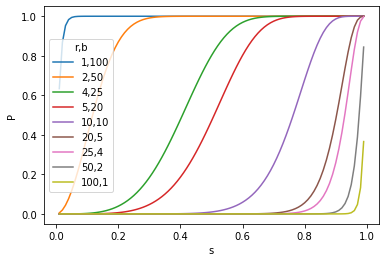

In [30]:
sns.lineplot(data=results, x='s', y='P', hue='r,b')